In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('churn_data.csv')
df.head(20)

,uuid,date,event
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact
5,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,big_purchase
6,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05-16,small_purchase
7,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-05,contact
8,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06-14,contact
9,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07-11,contact


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104103 entries, 0 to 104102
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uuid    104103 non-null  object
 1   date    104103 non-null  object
 2   event   104103 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


## EDA

In [4]:
print("Number of Events: ",df.shape[0])
print("Number of Unique Users: ",df.uuid.nunique())
print("Type of Events: ", df.event.unique()[0:3].tolist())

Number of Events:  104103
Number of Unique Users:  1034
Type of Events:  ['small_purchase', 'contact', 'big_purchase']


In [5]:
# column date to datetime instead object
# extract more info from date
df['date'] = pd.to_datetime(df['date'])
df['monthYear'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.to_period('M')
df['month'] = pd.to_datetime(df['date'],format='%Y-%m-%d').dt.month

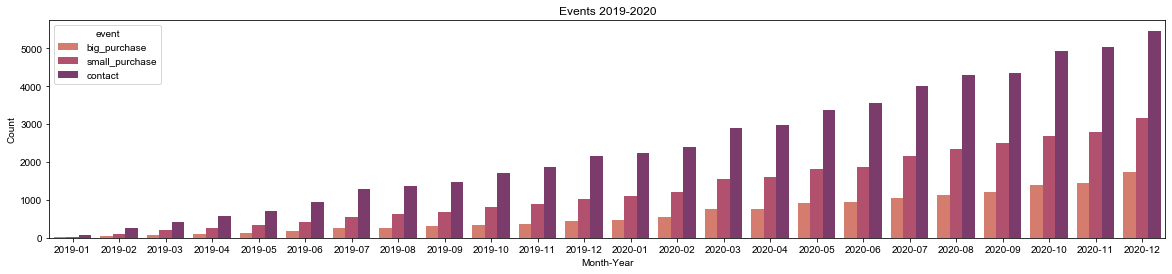

In [6]:
plt.figure(figsize=(20,4))
ax = sns.countplot(data=df.sort_values(by='monthYear',ascending=True),x="monthYear", 
                   hue="event",hue_order=['big_purchase','small_purchase','contact']
                   ,palette="flare")
sns.set(style="whitegrid")
plt.xlabel('Month-Year')
plt.ylabel('Count')
plt.title('Events 2019-2020')
plt.show()

## Interval Between Events / Cut Off Date

In [7]:
intervalBetweenEvents = []
intervalBetweenEvents.append(0)

for row in range(1,len(df)):
    if df.uuid[row] == df.uuid[row-1]:
        diffDates = abs(df.date[row] - df.date[(row-1)]).days
        intervalBetweenEvents.append(diffDates)
    else: intervalBetweenEvents.append(0)

df['interval'] = intervalBetweenEvents

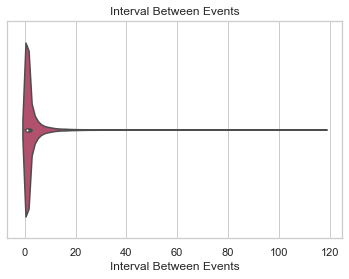

In [8]:
ax = sns.violinplot(data=df, x='interval',palette='flare')
plt.xlabel('Interval Between Events')
plt.title('Interval Between Events')
plt.show()

Calculating the optimal cut off date for determine customers that churned

In [9]:
def calcChurnFP(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    return print("False Positive:",falsePositive)

def calcChurnFPPerc(interval):
    falsePositive = df[df.interval > interval]['uuid'].nunique()
    numberUsers = df.uuid.nunique()
    return print("Percentage:",round((falsePositive/numberUsers)*100,2))

In [10]:
#calculating FP depending of interval
for i in range(60,95,5):
    print("Interval:",i," days")
    calcChurnFP(i)
    calcChurnFPPerc(i)
    print("-----------------------")

Interval: 60  days
False Positive: 40
Percentage: 3.87
-----------------------
Interval: 65  days
False Positive: 27
Percentage: 2.61
-----------------------
Interval: 70  days
False Positive: 21
Percentage: 2.03
-----------------------
Interval: 75  days
False Positive: 13
Percentage: 1.26
-----------------------
Interval: 80  days
False Positive: 8
Percentage: 0.77
-----------------------
Interval: 85  days
False Positive: 5
Percentage: 0.48
-----------------------
Interval: 90  days
False Positive: 3
Percentage: 0.29
-----------------------


## Feature Engineering

In [11]:
# categorical column
df.event.value_counts()

contact           58406
small_purchase    30741
big_purchase      14956
Name: event, dtype: int64

In [12]:
# categorical to numeric
eventsClass = {'contact': 1,'small_purchase': 2,'big_purchase': 3 }
df['eventsClass'] = df.event.replace(eventsClass)
df.head()

,uuid,date,event,monthYear,month,interval,eventsClass
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,0,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,13,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,51,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,7,1
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,11,1


In [13]:
# count number of events
df['eventNumber'] = df.groupby('uuid').cumcount()
df.head()

,uuid,date,event,monthYear,month,interval,eventsClass,eventNumber
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,0,2,0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,13,2,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,51,1,2
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,7,1,3
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,11,1,4


In [14]:
# count number of events of month
eventsMonth = df.groupby(['uuid','monthYear']).size().reset_index(name='numEventsMonth')
eventsMonth.head()

,uuid,monthYear,numEventsMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,4
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05,1
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06,2
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07,2


In [15]:
df = pd.merge(df,eventsMonth,how='left',on=['uuid','monthYear'])
df.head()

,uuid,date,event,monthYear,month,interval,eventsClass,eventNumber,numEventsMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,0,2,0,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,13,2,1,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,51,1,2,4
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,7,1,3,4
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,11,1,4,4


In [16]:
purchaseFilter = df.eventsClass != 1
purchaseMonth = df[purchaseFilter].groupby(['uuid','monthYear']).size().reset_index(name='purchaseMonth')
purchaseMonth.head()

,uuid,monthYear,purchaseMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02,2
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,1
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-05,1
3,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-11,2
4,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-12,2


In [17]:
df = pd.merge(df,purchaseMonth,how='left',on=['uuid','monthYear'])
df.fillna(0,inplace=True)
df.head()

,uuid,date,event,monthYear,month,interval,eventsClass,eventNumber,numEventsMonth,purchaseMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,0,2,0,2,2.0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,13,2,1,2,2.0
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,51,1,2,4,1.0
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,7,1,3,4,1.0
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,11,1,4,4,1.0


In [18]:
contactFilter = df.eventsClass == 1
contactMonth = df[contactFilter].groupby(['uuid','monthYear']).size().reset_index(name='contactMonth')
contactMonth.head()

,uuid,monthYear,contactMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04,3
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-06,2
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-07,2
3,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-09,1
4,0012c23d-379a-43fb-a91b-6f95c5358f52,2019-10,1


In [19]:
df = pd.merge(df,contactMonth,how='left',on=['uuid','monthYear'])
df.fillna(0,inplace=True)
df.head()

,uuid,date,event,monthYear,month,interval,eventsClass,eventNumber,numEventsMonth,purchaseMonth,contactMonth
0,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-07,small_purchase,2019-02,2,0,2,0,2,2.0,0.0
1,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-02-20,small_purchase,2019-02,2,13,2,1,2,2.0,0.0
2,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-12,contact,2019-04,4,51,1,2,4,1.0,3.0
3,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-19,contact,2019-04,4,7,1,3,4,1.0,3.0
4,00038504-c286-4c49-a6ed-d7853f65f7d6,2019-04-30,contact,2019-04,4,11,1,4,4,1.0,3.0


## Churn Classification

In [20]:
indexLastDate = df.groupby('uuid', as_index=False).nth(-1).index
df['churn'] = ['last' if x in indexLastDate else 0 for x in df.index]

In [21]:
from datetime import date

dayCalcChurn = pd.to_datetime(date(2021,1,1)) #first day of 2021 - to calculate probability of churn

daysLastEvent = []
for i in range(0,len(df)):
    diffDaysLast = abs(dayCalcChurn - df.date[i]).days
    daysLastEvent.append(diffDaysLast)

df['days_last_event'] = daysLastEvent


In [22]:
cutOffDate = 90
cond1 = df.churn == 'last'
cond2 = df.days_last_event > cutOffDate
df.loc[cond1 & cond2,'churn'] = 1


In [23]:
df.churn.value_counts()

0       103069
last       719
1          315
Name: churn, dtype: int64

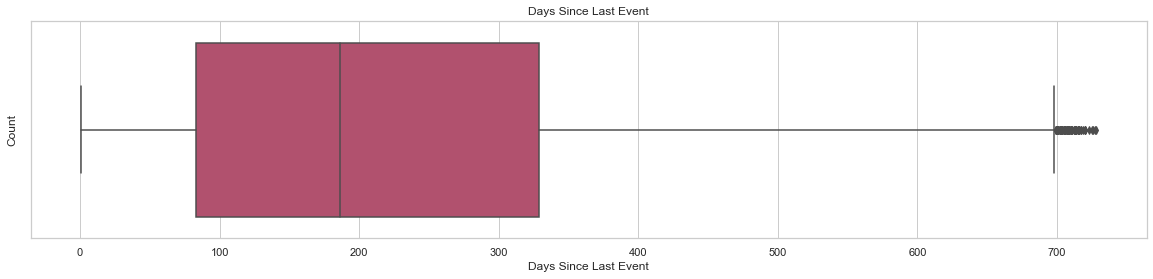

In [24]:
plt.figure(figsize=(20,4))
ax = sns.boxplot(data=df,x="days_last_event",palette="flare")
sns.set(style="whitegrid")
plt.xlabel('Days Since Last Event')
plt.ylabel('Count')
plt.title('Days Since Last Event')
plt.show()

## Churn Prediction

In [25]:
# the known values will be used for train and valid dataset
trainValid = df.loc[df.churn != 'last']
trainValid = trainValid[['month','interval','eventsClass','eventNumber',
                         'numEventsMonth','purchaseMonth','churn']]
print("Shape of Train + Valid dataset:",trainValid.shape)

Shape of Train + Valid dataset: (103384, 7)


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(trainValid.drop(columns=['churn']),trainValid['churn'], test_size=0.3,random_state=42)
print("Shape of X Train dataset: ",X_train.shape)
print("Shape of y Train dataset: ",y_train.shape)
print("Shape of X Valid dataset: ",X_valid.shape)
print("Shape of y Valid dataset: ",y_valid.shape)

Shape of X Train dataset:  (72368, 6)
Shape of y Train dataset:  (72368,)
Shape of X Valid dataset:  (31016, 6)
Shape of y Valid dataset:  (31016,)


In [27]:
# test dataset will alocate the unknown values that will be used for prediction
test = df.loc[df.churn == 'last']
X_test = test[['month','interval','eventsClass','eventNumber','numEventsMonth','purchaseMonth']]
print("Shape of Test dataset:",X_test.shape)

Shape of Test dataset: (719, 6)


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [29]:
names = ["Nearest_Neighbors","Decision_Tree", "Random_Forest","AdaBoost","Naive_Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB()]

In [30]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train.astype('int'))
    score = clf.score(X_valid, y_valid.astype('int'))
    scores.append(score)

models = pd.DataFrame()
models['name'] = names
models['score'] = scores
models.sort_values(by='score',ascending=False)

,name,score
2,Random_Forest,0.997098
0,Nearest_Neighbors,0.996905
1,Decision_Tree,0.996744
3,AdaBoost,0.996486
4,Naive_Bayes,0.940805


In [31]:
best_model = RandomForestClassifier(max_depth=5,n_estimators=200)

In [32]:
best_model.fit(X_train,y_train.astype('int'))
churnPredict = best_model.predict(X_test)

In [33]:
len(churnPredict)

719

In [34]:
#substituting for the values predicted by the model in the dataframe
df.loc[df.churn == 'last','churn'] = churnPredict

In [35]:
df.churn.value_counts()

0    103788
1       315
Name: churn, dtype: int64